# MicroB Prediction

__TRIN DATA FEATURES__


row_id,cfips,county,state,first_day_of_month
pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021
pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021
pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021
pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021
median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021

__FROM EXTERNAL__
Total!!Estimate!!Population 18 to 24 years!!Less than high school graduate!
Total!!Estimate!!Population 18 to 24 years!!High school graduate (includes equivalency)!
Total!!Estimate!!Population 18 to 24 years!!Some college or associate's degree!
Total!!Estimate!!Population 18 to 24 years!!Bachelor's degree or higher!

Total!!Estimate!!Population 25 years and over!!9th to 12th grade, no diploma!
Total!!Estimate!!Population 25 years and over!!High school graduate (includes equivalency)
Total!!Margin of Error!!Population 25 years and over!!Some college, no degree!2.png)
Total!!Estimate!!Population 25 years and over!!Associate's degree!
Total!!Estimate!!Population 25 years and over!!Bachelor's degree!
Total!!Estimate!!Population 25 years and over!!Graduate or professional degree!

__PREDICT__
microbusiness_density

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Data


In [258]:
df_train = pd.read_csv('/Users/joheunkang/microb/data/train.csv')
df_test = pd.read_csv('/Users/joheunkang/microb/data/test.csv')
df_census = pd.read_csv('/Users/joheunkang/microb/data/census_starter.csv')
df_s_a_edu21 = pd.read_csv('/Users/joheunkang/microb/data/external/state_a_2017_edu/ACSST1Y2017.S1501-Data.csv')


In [337]:
# Covid data 
# data souce : https://github.com/nytimes/covid-19-data
covid_20 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2020.csv")
covid_21 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2021.csv")
covid_22 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2022.csv")
covid_23 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2023.csv")
covid_recent = pd.read_csv("/Users/joheunkang/microb/data/us-counties-recent.csv")

# make class 

In [332]:
class Microb:
  def __init__(self,df,df_1):
    self.df = df  
    self.df1 = df_1

  def change_to_datetime(self):
    self.df['first_day_of_month'] = pd.to_datetime(self.df['first_day_of_month'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['first_day_of_month'].year)

  def create_m_month(self,row):
    return int(row['first_day_of_month'].month)

  def create_m_day(self,row):
    return int(row['first_day_of_month'].day)
  
  def get_m_year(self):
    self.df['m_year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['m_month']= self.df.apply(lambda row:self.create_m_month(row),axis = 1)
    self.df['m_day']= self.df.apply(lambda row:self.create_m_day(row),axis = 1)
      
  def get_first_day_of_prev_month(self):
    self.df['first_day_of_p1_m'] = self.df['first_day_of_month'] - pd.DateOffset(months=1)

  def get_first_day_of_prev_year(self):
    self.df['first_day_of_p1_y'] = self.df['first_day_of_month'] - pd.DateOffset(months=12)
  
  def collect_p1_kind(self,row,kind):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'pct_{kind}_{prev_year}']


  def merge(self):
    self.df = pd.merge(self.df, self.df1, on = 'cfips')
    
  def collect_p1_median_hh(self,row):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'median_hh_inc_{prev_year}']

    
  def get_p1_y_data(self):
    self.df['p1_y_bb'] = self.df.apply(lambda row: self.collect_p1_kind(row,'bb'),axis = 1)
    self.df['p1_y_college'] = self.df.apply(lambda row: self.collect_p1_kind(row,'college'),axis = 1)
    self.df['p1_y_foreign_born'] = self.df.apply(lambda row: self.collect_p1_kind(row,'foreign_born'),axis = 1)
    self.df['p1_y_it_workers'] = self.df.apply(lambda row: self.collect_p1_kind(row,'it_workers'),axis = 1)
    self.df['p1_y_median_hh_inc'] = self.df.apply(lambda row: self.collect_p1_median_hh(row),axis = 1)
    
  def create_p1_m_microb_density(self,row):
    is_exist =self.df[(self.df['cfips']==row['cfips'])&(self.df['first_day_of_month']==row['first_day_of_p1_m'])]
  
    if is_exist: 
      return is_exist['microbusiness_density']
    else: 
      return None
  def get_p1_m_microb_density(self):
    df["p1_m_microb_density"] = self.df.apply(lambda row: self.create_p1_m_microb_density(row),axis = 1)

  def get_df(self):
    return self.df 

In [333]:
d_train= Microb(df_train,df_census)
d_train.change_to_datetime()
d_train.get_m_year()
d_train.get_first_day_of_prev_month()
d_train.get_first_day_of_prev_year()
d_train.merge()
d_train.get_p1_y_data()
# d_train.get_p1_m_microb_density()
d = d_train.get_df()
d.head()

#d_train.get_first_day_of_prev_year()
#d = d_train.get_df()

# d_train.get_first_day_of_prev_year()
# d_train.get_p1_y_data()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0


In [334]:
print(len(d))

122265


In [335]:
temp = d[['cfips','first_day_of_month','microbusiness_density']]
temp = temp.rename(columns={"first_day_of_month":"first_day_of_p1_m"})
d= d.merge(temp, how='left', on=['cfips','first_day_of_p1_m'])
d= d.rename(columns={"microbusiness_density_y":"p1_m_mcrob_density"})

In [336]:
d.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.007682
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.884870
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.055843
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.993233


In [700]:
d.to_csv('d.csv')

p6_m_mcrob_density may needed : most buisness takes 6 month to open

# Covid data
- covid data and given data has different county name: use cfips and fips to merge those to table

In [551]:
df_covid = pd.concat([covid_20,covid_21,covid_22,covid_23,covid_recent],axis = 0)
df_covid.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m
0,2020-01-21 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
1,2020-01-22 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
2,2020-01-23 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
3,2020-01-24 00:00:00,Cook,Illinois,17031.0,1,0.0,2020.0,1.0,1.0,2020-01-01
4,2020-01-24 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01


In [558]:
class Covid:
  def __init__(self,df):
    self.df = df
    self.df['date'] = pd.to_datetime(self.df['date'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['date'].year)

  def create_m_month(self,row):
    return int(row['date'].month)
  
  def get_y_m_d(self):
    self.df['year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['month']= self.df.apply(lambda row: self.create_m_month(row),axis = 1)
    self.df['day'] = 1
      
#   def create_first_day_of_p1_m(self,row):
#     return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
  
  def get_first_day_of_p1_m(self):  
    def create_first_day_of_p1_m(row):
      return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
    self.df['first_day_of_p1_m'] = self.df.apply(lambda row: create_first_day_of_p1_m(row),axis = 1)
    return self.df 
  
  # collect groupby monthly mean, median for  
  def collect_county_m_case_mean(self):
    return self.df.groupby(['fips','year','month'])[['cases']].mean().rename(columns = {'cases':'county_m_case_mean'}).reset_index()

  def collect_county_m_case_median(self):
    return self.df.groupby(['fips','year','month'])[['cases']].median().rename(columns= {'cases':'county_m_case_median'}).reset_index()

  def collect_county_m_death_mean(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].mean().rename(columns = {'deaths':'county_m_deaths_mean'}).reset_index()

  def collect_county_m_death_median(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].median().rename(columns= {'deaths':'county_m_deaths_median'}).reset_index()
  
  def merge_case_death(self):
    self.df = pd.merge(self.df,self.collect_county_m_case_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_case_median(), on =['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_median(), on =['fips','year','month'])
  
  def drop_cols(self):
    self.df = self.df.drop(['date', 'cases','deaths'], axis=1)
    self.df = self.df.drop_duplicates()
    
  def get_data(self):
    return self.df 
  


In [560]:
# covid_2020
CovidData= Covid(covid_20)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_20 = CovidData.get_first_day_of_p1_m()


In [561]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [562]:
# covid_2021
CovidData= Covid(covid_21)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_21 = CovidData.get_first_day_of_p1_m()

In [563]:
# covid_2022
CovidData= Covid(covid_22)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_22 = CovidData.get_first_day_of_p1_m()

In [564]:
# covid_2023
CovidData= Covid(covid_23)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_23 = CovidData.get_first_day_of_p1_m()

In [565]:
df_covid_20.to_csv('df_covid_20.csv')
df_covid_21.to_csv('df_covid_21.csv')
df_covid_22.to_csv('df_covid_22.csv')
df_covid_23.to_csv('df_covid_23.csv')

In [566]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [542]:
merged = merged.drop(columns = ['index'])
merged

,county,state,year,month,county_m_case_mean,county_m_deaths_mean,county_m_case_median,county_m_deaths_median,day,first_day_of_p1_m
0,Abbeville,South Carolina,2020,3,2.461538,0.000000,3.0,0.0,1,2020-03-01
1,Abbeville,South Carolina,2020,4,14.333333,0.000000,10.0,0.0,1,2020-04-01
2,Abbeville,South Carolina,2020,5,34.838710,0.000000,34.0,0.0,1,2020-05-01
3,Abbeville,South Carolina,2020,6,72.900000,0.000000,71.5,0.0,1,2020-06-01
4,Abbeville,South Carolina,2020,7,192.225806,2.096774,170.0,2.0,1,2020-07-01
...,...,...,...,...,...,...,...,...,...,...
115401,Zapata,Texas,2023,2,4469.888889,57.000000,4469.0,57.0,1,2023-02-01
115402,Zavala,Texas,2023,1,4495.129032,70.000000,4496.0,70.0,1,2023-01-01
115403,Zavala,Texas,2023,2,4516.277778,70.000000,4518.0,70.0,1,2023-02-01
115404,Ziebach,South Dakota,2023,1,707.451613,12.903226,707.0,13.0,1,2023-01-01


In [567]:
def drop_covid_duplicates(df):
  return df.drop_duplicates(subset = ['fips','year','month'])

In [568]:
df_covid_20 = drop_covid_duplicates(df_covid_20)
df_covid_21 = drop_covid_duplicates(df_covid_21)
df_covid_22 = drop_covid_duplicates(df_covid_22)
df_covid_23 = drop_covid_duplicates(df_covid_23)


In [574]:
def concat_covid_data(df1,df2,df3,df4):
  df1.rename(columns={'fips':'cfips'})
  df2.rename(columns={'fips':'cfips'})
  df3.rename(columns={'fips':'cfips'})
  df4.rename(columns={'fips':'cfips'})
  return pd.concat([df1,df2,df3,df4],axis = 0)


In [575]:
covid_all = concat_covid_data(df_covid_20,df_covid_21,df_covid_22,df_covid_23)

In [576]:
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
11,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
19,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
26,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
32,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [577]:
covid_all.to_csv('covid_all.csv')

In [578]:
covid_all = covid_all.reset_index(drop=True)
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [580]:
print(len(covid_all))

114082


In [586]:
covid_all.head()

,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [ ]:
def drop_covid_date(df):
  return df.drop(columns =['date'])

In [590]:
def rename_fips_2_cfips(df):
  df = df.rename(columns = {'fips':'cfips'})
  df = df.astype({"cfips": int})
  return df 

def merge_with_covid(df,covid_df):
  return pd.merge(df,covid_df,how= "left",on=["cfips","first_day_of_p1_m"]) 

In [587]:
covid_all = rename_fips_2_cfips(covid_all)


In [588]:
covid_all.head()

,county,state,cfips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [591]:
final_df = merge_with_covid(d,covid_all) ###############merge to make final data ####################3

In [593]:
print(len(final_df))
final_df.head(50)

122265


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,1,...,Alabama,1.0,0.0,2020.0,3.0,1.0,5.375000,6.0,0.000000,0.0
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,1,...,Alabama,10.0,0.0,2020.0,4.0,1.0,24.366667,25.0,1.500000,1.0


In [594]:
final_df.to_csv('final_df.csv')

# New start

In [6]:
final_df = pd.read_csv('final_df.csv',index_col = [0])
final_df.head()


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Drop duplicated columns 

In [7]:
def clean_columns(df):
  df = df.drop(columns = ['county_y','state_y'])
  df = df.rename(columns = {'county_x':'county', 'state_x':'state'})
  return df 


In [8]:
re_df = clean_columns(final_df)

In [9]:
re_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,p1_m_mcrob_density,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,3.007682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,2.884870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,3.055843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,2.993233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Seasonality Check 

In [599]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
df_ex1 = re_df[(re_df['county']=='Orange County') & (re_df['state']=='California')]
df_ex1_year = df_ex1[6::]
df_ex1_year = df_ex1_year.reset_index(drop=True)
df_ex1_year.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,p1_m_mcrob_density,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,6059_2020-02-01,6059,Orange County,California,2020-02-01,17.522627,429829,2020,2,1,...,17.743134,1.0,0.0,2020.0,1.0,1.0,1.000000,1.0,0.000000,0.0
1,6059_2020-03-01,6059,Orange County,California,2020-03-01,17.363638,425929,2020,3,1,...,17.522627,1.0,0.0,2020.0,2.0,1.0,1.000000,1.0,0.000000,0.0
2,6059_2020-04-01,6059,Orange County,California,2020-04-01,17.809828,436874,2020,4,1,...,17.363638,1.0,0.0,2020.0,3.0,1.0,104.161290,22.0,0.741935,0.0
3,6059_2020-05-01,6059,Orange County,California,2020-05-01,17.186588,421586,2020,5,1,...,17.809828,606.0,10.0,2020.0,4.0,1.0,1437.233333,1400.5,25.933333,23.5
4,6059_2020-06-01,6059,Orange County,California,2020-06-01,17.152834,420758,2020,6,1,...,17.186588,2591.0,50.0,2020.0,5.0,1.0,4305.774194,4281.0,94.806452,86.0
5,6059_2020-07-01,6059,Orange County,California,2020-07-01,17.208115,422114,2020,7,1,...,17.152834,6532.0,147.0,2020.0,6.0,1.0,9379.166667,8879.0,236.266667,227.0
6,6059_2020-08-01,6059,Orange County,California,2020-08-01,17.214310,422266,2020,8,1,...,17.208115,14413.0,345.0,2020.0,7.0,1.0,27001.935484,27904.0,465.677419,466.0
7,6059_2020-09-01,6059,Orange County,California,2020-09-01,17.159887,420931,2020,9,1,...,17.214310,36833.0,649.0,2020.0,8.0,1.0,43081.935484,43709.0,807.354839,810.0
8,6059_2020-10-01,6059,Orange County,California,2020-10-01,17.123402,420036,2020,10,1,...,17.159887,48825.0,988.0,2020.0,9.0,1.0,52424.900000,52401.0,1115.800000,1108.0
9,6059_2020-11-01,6059,Orange County,California,2020-11-01,17.040319,417998,2020,11,1,...,17.123402,55437.0,1275.0,2020.0,10.0,1.0,58492.225806,58354.0,1379.193548,1401.0


In [687]:
df_ex2 = re_df[(re_df['county']=='Orange County') & (re_df['state']=='California')]
df_ex2_year = df_ex2[15::]
df_ex2_year = df_ex2_year.reset_index(drop=True)
df_ex2_year.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,p1_m_mcrob_density,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,6059_2020-11-01,6059,Orange County,California,2020-11-01,17.040319,417998,2020,11,1,...,17.123402,55437.0,1275.0,2020.0,10.0,1.0,58492.225806,58354.0,1379.193548,1401.0
1,6059_2020-12-01,6059,Orange County,California,2020-12-01,16.997229,416941,2020,12,1,...,17.040319,62080.0,1484.0,2020.0,11.0,1.0,68972.266667,67629.0,1529.333333,1526.0
2,6059_2021-01-01,6059,Orange County,California,2021-01-01,16.860846,415373,2021,1,1,...,16.997229,81631.0,1577.0,2020.0,12.0,1.0,117513.322581,113492.0,1719.709677,1718.0
3,6059_2021-02-01,6059,Orange County,California,2021-02-01,16.168304,398312,2021,2,1,...,16.860846,166196.0,1875.0,2021.0,1.0,1.0,214002.129032,221532.0,2358.774194,2320.0
4,6059_2021-03-01,6059,Orange County,California,2021-03-01,16.331079,402322,2021,3,1,...,16.168304,247035.0,3109.0,2021.0,2.0,1.0,255788.357143,256889.0,3571.428571,3577.0
5,6059_2021-04-01,6059,Orange County,California,2021-04-01,16.423588,404601,2021,4,1,...,16.331079,261408.0,3921.0,2021.0,3.0,1.0,263981.225806,264033.0,4436.032258,4486.0
6,6059_2021-05-01,6059,Orange County,California,2021-05-01,16.410801,404286,2021,5,1,...,16.423588,266353.0,4755.0,2021.0,4.0,1.0,268475.666667,268692.0,4863.366667,4877.5
7,6059_2021-06-01,6059,Orange County,California,2021-06-01,16.411045,404292,2021,6,1,...,16.410801,270194.0,4965.0,2021.0,5.0,1.0,271197.967742,271251.0,5025.000000,5031.0
8,6059_2021-07-01,6059,Orange County,California,2021-07-01,16.429838,404755,2021,7,1,...,16.411045,272156.0,5065.0,2021.0,6.0,1.0,272812.333333,272807.0,5100.833333,5104.0
9,6059_2021-08-01,6059,Orange County,California,2021-08-01,16.478712,405959,2021,8,1,...,16.429838,273636.0,5125.0,2021.0,7.0,1.0,276618.129032,275358.0,5135.870968,5136.0


In [27]:
# seasonality by county 
# get example county and check seasonality 
def check_sesaon(df): 
  #df.set_index('first_day_of_month', inplace=True)
  analysis = df[['microbusiness_density_x']].copy()
  #analysis = df[['county_m_case_median']].copy()
  #series = [i for i in range(6,17)]
  decompose_result_mult = seasonal_decompose(analysis,model="additive",period=12)
  
  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid
  plt.figure(figsize=(25, 2))
  fig = decompose_result_mult.plot()
  #decompose_result_mult.plot()
  fig.set_size_inches((30, 9))
  # Tight layout to realign things
  fig.tight_layout()
  plt.show()


<Figure size 1800x144 with 0 Axes>

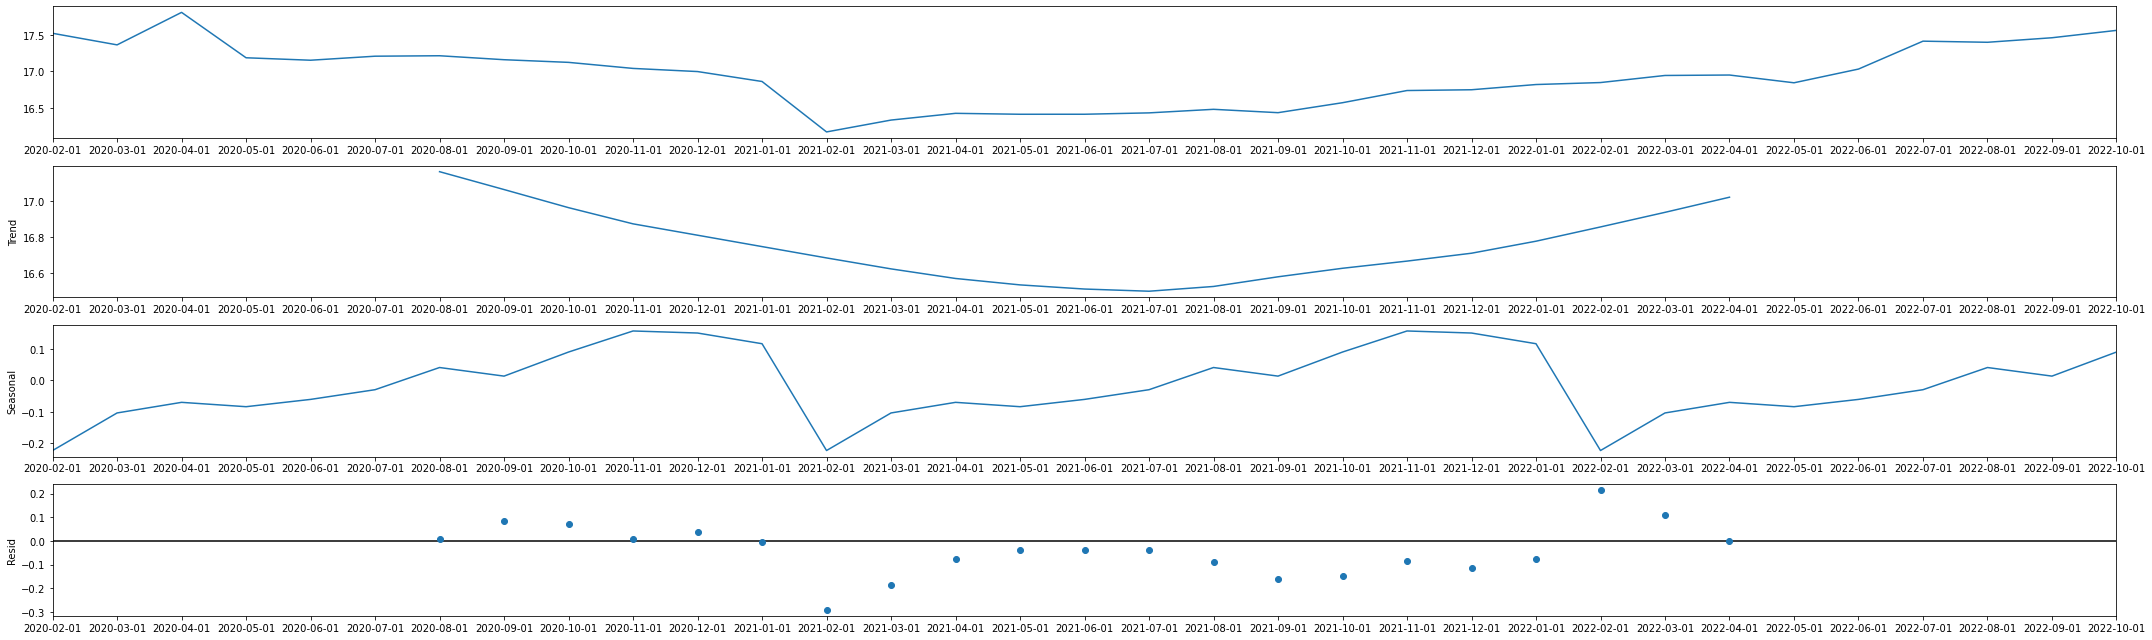

In [28]:
check_sesaon(df_ex1_year)

__each state has their seasonality__: 
for each state, use seasonality. since it has year/month seasonaliyt, we use month and year feature to indicate seasonality




https://towardsdatascience.com/taking-seasonality-into-consideration-for-time-series-analysis-4e1f4fbb768f

__county_m_case_median__ also has year seasonality (but all counties are similar)

stationary vs non-stationary : looks like none stationary because each year has differnt value 

multiplicative vs additive : ? 

## Augmented Dickey-Fuller Test (ADF Test)
https://medium.com/swlh/seasonality-analysis-and-forecast-in-time-series-b8fbba820327

- to check stationary: we canot create a time series model unless our series is stationary
if not stationary, we have to make the sereis stationary

A stationary series is one in which the properties — mean, variance and covariance, do not vary with time.

The null(H0) and alternate hypothesis(H1) of this test are:

H0: The series has a unit root (value of a =1),the series is non-stationary.

H1: The series has no unit root, the series is stationary.

In [29]:
from statsmodels.tsa.stattools import adfuller

In [41]:
def adf_test(data):
  print('adf testing')
  test_res = adfuller(data['microbusiness_density_x'],autolag = "AIC")
  # 'AIC': auto lag calculation
  # return: adf(test statistics), pvalue, usedlag, nobs(number of observations used for adf regression and calc of critical value )
  # critical values, 1,5,10 level, icvest: max info criterion of autolag is not None, resstre: dummyclasse 
  return test_res


  

In [42]:
adf_test(df_ex1_year)

adf testing


(-1.4517343889527279,
 0.5572383821637004,
 0,
 32,
 {'1%': -3.653519805908203,
  '5%': -2.9572185644531253,
  '10%': -2.6175881640625},
 -6.7667627753430395)

p_val: 0.557 > 1% and 5% and 10% and p>0.05 -> we cannot reject H0-> __None stationary__
if the data is none stationary, we can fit __ARMIA__ and __Seasonal ARIMA (SARMIMA)__

# Feature Engineering 

In [691]:
re_df.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density_x', 'active', 'm_year', 'm_month', 'm_day',
       'first_day_of_p1_m', 'first_day_of_p1_y', 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021', 'p1_y_bb', 'p1_y_college',
       'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc',
       'p1_m_mcrob_density', 'cases', 'deaths', 'year', 'month', 'day',
       'county_m_case_mean', 'county_m_case_median', 'county_

In [694]:
df_fe = re_df.drop(columns=["row_id", "cfips", "first_day_of_month", 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',
        "first_day_of_p1_m","first_day_of_p1_y"
])
df_fe.head()

,county,state,microbusiness_density_x,active,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Autauga County,Alabama,3.007682,1249,2019,8,1,78.9,15.9,2.0,1.1,58786.0,NaN,NaN,NaN,NaN,NaN
1,Autauga County,Alabama,2.884870,1198,2019,9,1,78.9,15.9,2.0,1.1,58786.0,3.007682,NaN,NaN,NaN,NaN
2,Autauga County,Alabama,3.055843,1269,2019,10,1,78.9,15.9,2.0,1.1,58786.0,2.884870,NaN,NaN,NaN,NaN
3,Autauga County,Alabama,2.993233,1243,2019,11,1,78.9,15.9,2.0,1.1,58786.0,3.055843,NaN,NaN,NaN,NaN
4,Autauga County,Alabama,2.993233,1243,2019,12,1,78.9,15.9,2.0,1.1,58786.0,2.993233,NaN,NaN,NaN,NaN


In [693]:
print(len(df_fe))

122265


# Feature Encoding 

In [ ]:
# unneccesary: row_id, cfips, first_day_of_month, 'pct_bb_2017', 'pct_bb_2018',
#        'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
#        'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
#        'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
#        'pct_foreign_born_2019', 'pct_foreign_born_2020',
#        'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
#        'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
#        'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
#        'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',

# categorical variables (nominal: no numeric realationship): county, state 
# oridnal: year, 


In [696]:
# onehot encoder for county and state (nominal)
one_hot_encoded_data = pd.get_dummies(df_fe, columns = ['county', 'state'])
one_hot_encoded_data

,microbusiness_density_x,active,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,3.007682,1249,2019,8,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
1,2.884870,1198,2019,9,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
2,3.055843,1269,2019,10,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
3,2.993233,1243,2019,11,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
4,2.993233,1243,2019,12,1,78.9,15.9,2.0,1.1,58786.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,1.803249,101,2022,6,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122261,1.803249,101,2022,7,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122262,1.785395,100,2022,8,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1
122263,1.785395,100,2022,9,1,81.3,13.9,1.6,0.0,65566.0,...,0,0,0,0,0,0,0,0,0,1


In [699]:
df_fe.head()

,county,state,microbusiness_density_x,active,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Autauga County,Alabama,3.007682,1249,2019,8,1,78.9,15.9,2.0,1.1,58786.0,NaN,NaN,NaN,NaN,NaN
1,Autauga County,Alabama,2.884870,1198,2019,9,1,78.9,15.9,2.0,1.1,58786.0,3.007682,NaN,NaN,NaN,NaN
2,Autauga County,Alabama,3.055843,1269,2019,10,1,78.9,15.9,2.0,1.1,58786.0,2.884870,NaN,NaN,NaN,NaN
3,Autauga County,Alabama,2.993233,1243,2019,11,1,78.9,15.9,2.0,1.1,58786.0,3.055843,NaN,NaN,NaN,NaN
4,Autauga County,Alabama,2.993233,1243,2019,12,1,78.9,15.9,2.0,1.1,58786.0,2.993233,NaN,NaN,NaN,NaN


In [701]:
df_fe.to_csv('df_fe.csv')

In [702]:
print(len(df_fe))

122265


# Drop rows that contain nan

In [704]:
df_fe_no_nan = df_fe.dropna(axis = 0)
print(len(df_fe_no_nan))

95287


In [706]:
95287/122265 * 100 # only drops 22 percent of the data when remove the nan value rows 

77.93481372428741

# Train and Test Data

In [711]:
test_data = df_fe_no_nan[(df_fe_no_nan['m_year']==2022)&(df_fe_no_nan['m_month']==10)] 
train_data= df_fe_no_nan[(df_fe_no_nan['m_year']!=2022)|(df_fe_no_nan['m_month']!=10)]

In [712]:
print(len(test_data))
print(len(train_data))

3125
92162


In [713]:
test_data

,county,state,microbusiness_density_x,active,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
38,Autauga County,Alabama,3.463856,1472,2022,10,1,85.5,16.4,2.1,1.1,62660.0,3.442677,18264.400000,18303.0,225.833333,227.0
77,Baldwin County,Alabama,8.359798,14320,2022,10,1,87.9,20.6,3.5,1.3,64346.0,8.341701,65196.833333,65353.0,704.766667,705.0
116,Barbour County,Alabama,1.232074,244,2022,10,1,64.6,6.7,2.6,0.8,36422.0,1.206827,6838.366667,6873.0,101.366667,101.0
155,Bibb County,Alabama,1.287240,229,2022,10,1,74.6,7.9,1.1,2.1,54277.0,1.315346,7461.833333,7481.0,106.533333,107.0
194,Blount County,Alabama,1.831783,813,2022,10,1,81.0,9.3,4.5,0.9,52830.0,1.852060,16746.333333,16793.0,255.433333,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122108,Sweetwater County,Wyoming,2.823801,905,2022,10,1,88.4,12.4,5.5,1.0,76668.0,2.811320,12111.466667,12117.0,130.000000,130.0
122147,Teton County,Wyoming,26.273220,5035,2022,10,1,90.5,38.3,11.1,2.0,94498.0,26.090586,11596.200000,11583.0,16.000000,16.0
122186,Uinta County,Wyoming,4.009369,582,2022,10,1,90.6,12.3,2.9,0.9,75106.0,3.995591,6098.100000,6102.0,40.600000,41.0
122225,Washakie County,Wyoming,3.126551,189,2022,10,1,85.4,17.2,1.0,1.1,62271.0,3.209264,2643.933333,2642.0,47.000000,47.0


# Numeric Featuer Normalization

In [ ]:
# scaling: standard,minimax


# Model Fitting 
- since their seasonality is strong, we may not need complicated model: try simple models such as linear regression,lasso, ridge regresson, svm, polynomial, 
- then try tree methods 
- we won't need any complicated deep learning model for this problem 